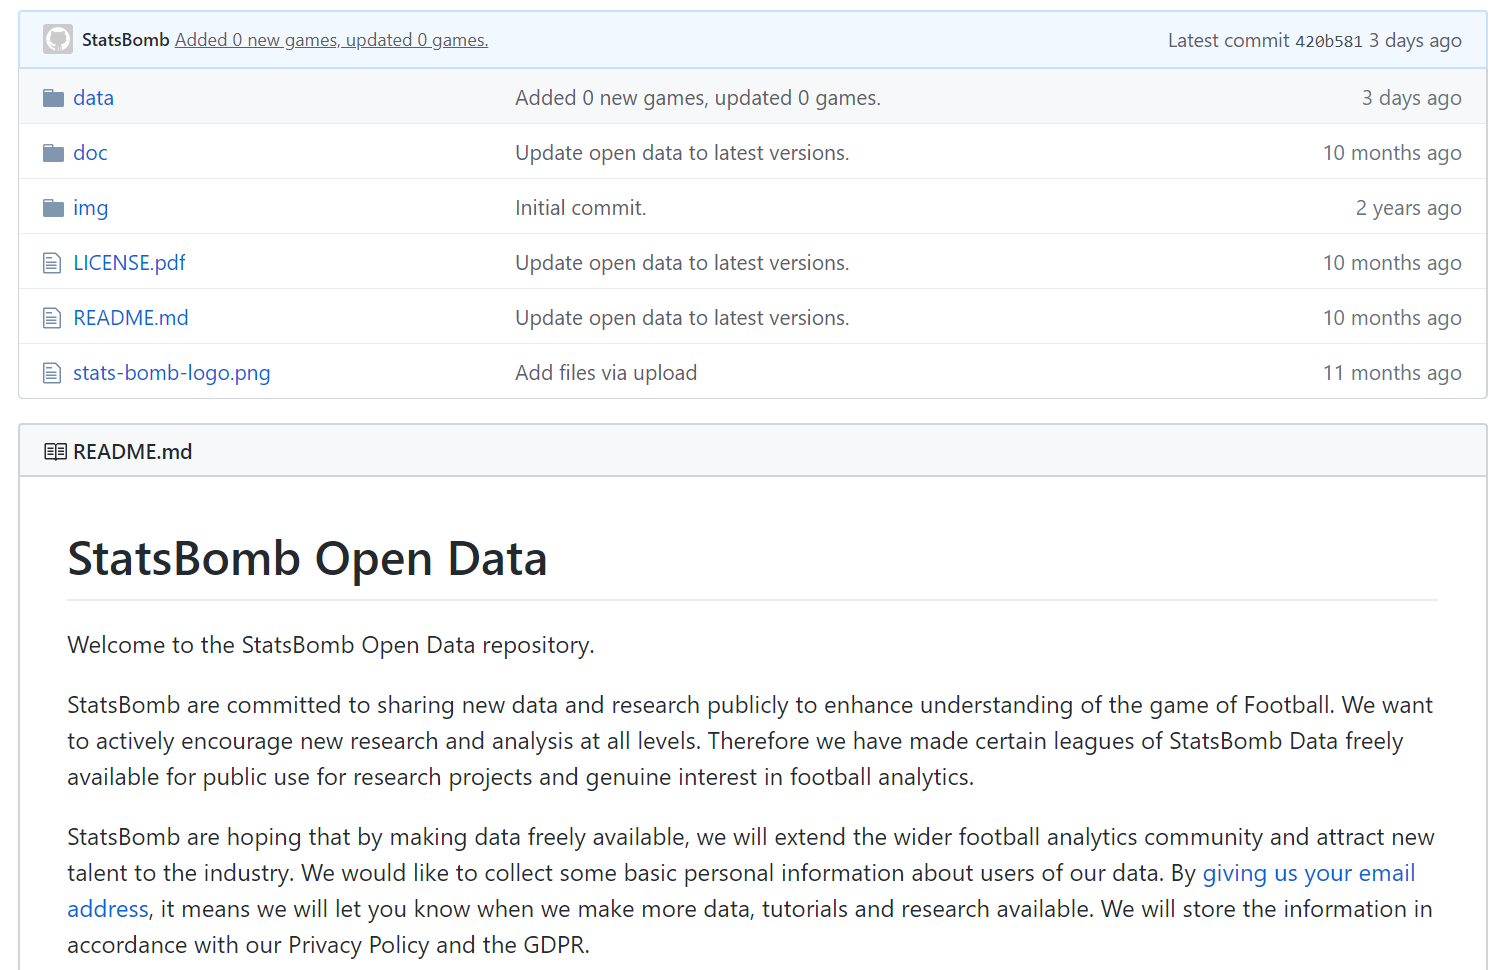

# Packages to use
---

In [1]:
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

# Data Collection
---
The data from the `StatsBomb` dataset has been downloaded locally. We will base on all matches in each competition to have a sufficiently high amount of records.

Fortunately, the Statsbomb has provided a detailed glossary and explanation of the nomenclature to identify and extract the necessary data.

## Matches information
---

In [4]:
filepath = "..\open-data-statsbomb\\data\\matches\\"
competitions = ['11','43'] #,'37','40','49','72']
league_list = []
for comp in competitions:
    path = filepath+comp
    league_list.extend(glob.glob(path+"\*.json"))
print("Ficheros:", str(league_list))

Ficheros: ['..\\open-data-statsbomb\\data\\matches\\11\\1.json', '..\\open-data-statsbomb\\data\\matches\\11\\2.json', '..\\open-data-statsbomb\\data\\matches\\11\\21.json', '..\\open-data-statsbomb\\data\\matches\\11\\22.json', '..\\open-data-statsbomb\\data\\matches\\11\\23.json', '..\\open-data-statsbomb\\data\\matches\\11\\24.json', '..\\open-data-statsbomb\\data\\matches\\11\\25.json', '..\\open-data-statsbomb\\data\\matches\\11\\26.json', '..\\open-data-statsbomb\\data\\matches\\11\\27.json', '..\\open-data-statsbomb\\data\\matches\\11\\37.json', '..\\open-data-statsbomb\\data\\matches\\11\\38.json', '..\\open-data-statsbomb\\data\\matches\\11\\39.json', '..\\open-data-statsbomb\\data\\matches\\11\\4.json', '..\\open-data-statsbomb\\data\\matches\\11\\40.json', '..\\open-data-statsbomb\\data\\matches\\11\\41.json', '..\\open-data-statsbomb\\data\\matches\\11\\42.json', '..\\open-data-statsbomb\\data\\matches\\43\\3.json']


We store information related to each of the matches that we will later use to clarify each of the instances of our data set.

In [5]:
match_list = []
match_dates = []
info_match = {}
competition = []
season = []
home_list = []
away_list = []
finalResult = []

for league in league_list:
    df_matches = pd.read_json(league, encoding='utf8')
    match_list.extend(df_matches['match_id'].values)
    match_dates.extend(df_matches['match_date'])
    for i in range(df_matches.shape[0]):
        info_match[df_matches['match_id'][i]] = [df_matches['competition'][i]['competition_name'], 
                                                 df_matches['season'][i]['season_name'], 
                                                 df_matches['match_date'][i]]
        home_list.append(df_matches['home_team'].values[i]['home_team_name'])
        away_list.append(df_matches['away_team'].values[i]['away_team_name'])
        finalResult.append(str(df_matches['home_score'][i]) + '-' + str(df_matches['away_score'][i]))
        
teams = [(a,b) for a,b in zip(home_list, away_list)]
comb_list = list(zip(match_list,teams))
match_dict = {match_id:teams_id for match_id,teams_id in comb_list}
match_scores = {match_id:scores for match_id,scores in list(zip(match_list, finalResult))}

We downloaded the specific information of the shots:

In [6]:
eventspath = "..\open-data-statsbomb\\data\\events\\"
date_list = []
competition_list = []
season_list = []
score = []
shots = []
coordinates = []
endLocation = []
coordinatesGoalkeeper = []
situation = []
timestamp = []
result = []
bodyPart = []
technique = []
playType = []
firstTime = []
xG = []
keyPassType = []
isCrossKeyPass = []
isCutBackKeyPass = [] 
player = []
underPressure = []
playerPosition = []
playerTeam = []
opponentTeam = []
homeAway = []
playerAssisted = []
lastAction = []
lastActionPlayer = []
lastActionPossesionTeam = []
playersBetweenShotAndGoal = []

In [7]:
for match in match_list:
    competition = info_match[match][0]
    season = info_match[match][1]
    date = info_match[match][2]
    matchname = str(match)
    path = eventspath+matchname+".json"
    df_events = pd.read_json(path, encoding='utf-8')
    df_shots = df_events[df_events.shot.notnull()].reset_index(drop=True)
    df_shots = df_shots[['index', 'timestamp', 'shot', 'location', 'player', 'position', 
                         'team', 'play_pattern', 'under_pressure']]
    shots.append(df_shots.shape[0])
    coordinates.extend(list(df_shots['location'].values))
    timestamp.extend(list(df_shots['timestamp'].values))
    for i in range(len(df_shots)):
        competition_list.append(competition)
        season_list.append(season)
        score.append(match_scores[match])
        date_list.append(date)
        endLocation.append(df_shots.iloc[i][2]['end_location'])
        result.append(df_shots.iloc[i][2]['outcome']['name'])
        bodyPart.append(df_shots.iloc[i][2]['body_part']['name'])
        technique.append(df_shots.iloc[i][2]['technique']['name'])
        playType.append(df_shots.iloc[i][2]['type']['name'])
        player.append(df_shots.iloc[i][4]['name'])
        playerPosition.append(df_shots.iloc[i][5]['name'])
        playerTeam.append(df_shots.iloc[i][6]['name'])
        situation.append(df_shots.iloc[i][7]['name'])
        underPressure.append(df_shots.iloc[i][-1])
        if df_shots.iloc[i][6]['name'] == match_dict[match][0]:
            homeAway.append('home')
            opponentTeam.append(match_dict[match][1])
        else:
            homeAway.append('away')
            opponentTeam.append(match_dict[match][0])
        
        if 'first_time' in df_shots.iloc[i][2].keys():
            firstTime.append(df_shots.iloc[i][2]['first_time'])
        else:
            firstTime.append(False)
            
        if 'key_pass_id' in df_shots.iloc[i][2].keys():
            key_pass = df_shots.iloc[i][2]['key_pass_id']
            pass_info = df_events[df_events['id']==key_pass].dropna(axis='columns')['pass']
            keyPassType.append(pass_info.iloc[0]['height']['name'])
            if 'cross' in pass_info.iloc[0].keys():
                isCrossKeyPass.append(True)
            else:
                isCrossKeyPass.append(False)
            if 'cut_back' in pass_info.iloc[0].keys():
                isCutBackKeyPass.append(True)
            else:
                isCutBackKeyPass.append(False)
            if any(x in ['shot_assist','goal_assist'] for x in list(pass_info.iloc[0].keys())):
                playerAssisted.append(df_events[df_events['id']==key_pass]['player'].iloc[0]['name'])
            else:
                playerAssisted.append('None')
        else:
            keyPassType.append('None')
            isCutBackKeyPass.append(False)
            isCrossKeyPass.append(False)
            playerAssisted.append('None')
            
        idx_filt = df_shots.iloc[i,0]-1
        filt = df_events['index']==idx_filt
        df_events_filt = df_events[filt].dropna(axis='columns')
        lastAction.append(df_events_filt['type'].values[0]['name'])
        try:
            lastActionPlayer.append(df_events_filt['player'].values[0]['name'])
        except:
            lastActionPlayer.append(np.nan)
        lastActionPossesionTeam.append(df_events_filt['possession_team'].values[0]['name'])

        xG.append(df_shots.iloc[i][2]['statsbomb_xg'])
        
endLocation = [endLocation[i][:2] for i in range(len(endLocation))]

One of the most interesting things about the data is that it contains the exact locations of all players at the time of the shot. 

Next, a function is defined that calculates the number of players between the shot and the goal. To do this, consider the triangle created by the location of the shot and the edges of the goal. Then evaluate each player's location to see if it is in the triangle. The number of players in the triangle will be stored as `playersBetweenShotAndGoal`.

In [9]:
def vectorize(a, b):
    return [b[0]-a[0], b[1]-a[1]]

def isInside(loc_shoot, point_goal1, point_goal2, loc_player):
    v2 = vectorize(loc_player, loc_shoot)
    v0 = vectorize(point_goal1, loc_shoot)
    v1 = vectorize(point_goal2, loc_shoot)
    u = (np.dot(v1, v1)*np.dot(v2, v0)-np.dot(v1, v0)*np.dot(v2, v1)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))
    v = (np.dot(v0, v0)*np.dot(v2, v1)-np.dot(v0, v1)*np.dot(v2, v0)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))
    if u < 0 or v < 0:
        return False
    elif u > 1 or v > 1:
        return False
    elif u+v > 1:
        return False
    else:
        return True
    

for match in match_list:
    matchname = str(match)
    path = eventspath+matchname+".json"
    df_events = pd.read_json(path, encoding='utf-8')
    df_shots = df_events[df_events.shot.notnull()].reset_index(drop=True)
    df_shots = df_shots[['index', 'timestamp', 'shot', 'location', 'player', 
                         'position', 'possession_team', 'under_pressure']]
    for i in range(len(df_shots)):
        loc_shoot = df_shots['location'].iloc[i]
        freeze_frame_list = []
        if 'freeze_frame' in df_shots['shot'].iloc[i].keys():
            names = []
            for j in range(len(df_shots['shot'].iloc[i]['freeze_frame'])):
                element_j = df_shots['shot'].iloc[i]['freeze_frame'][j]
                freeze_frame_list.append(isInside(loc_shoot, [120,36], [120,44], element_j['location']))
                if (element_j['position']['name'] == 'Goalkeeper') and (not element_j['teammate']):
                    coordinatesGoalkeeper.append(element_j['location'])
                    names.append(element_j['position']['name'])
            if "Goalkeeper" not in names:
                coordinatesGoalkeeper.append([np.nan, np.nan]) # 39
        else: # Penalty (freeze_frame = 1 y coordenadas_goalkeeper = [120,40])
            freeze_frame_list.append(1) 
            coordinatesGoalkeeper.append([120, 40])
        playersBetweenShotAndGoal.append(sum(freeze_frame_list))

Calculation of the distance to the goal and the angle of the shot:

In [10]:
df = pd.DataFrame(coordinates, columns=['x','y'])

df['distance'] = round(np.sqrt((df['x']-120)**2+(df['y']-40)**2),1)
df['shot_a'] = np.sqrt((df['x']-120)**2+(df['y']-36)**2)
df['shot_b'] = np.sqrt((df['x']-120)**2+(df['y']-44)**2)

df['angle'] = np.arccos((df['shot_a']**2+df['shot_b']**2-64)/(2*df['shot_a']*df['shot_b']))
df['angle'] = np.degrees(df['angle'])
df['angle'] = round(df['angle'],1)

Añadiendo el resto de las características al dataset:

In [11]:
df['date'] = date_list
df['competition'] = competition_list
df['season'] = season_list
df['score'] = score
df['situation'] = situation
df['player'] = player
df['playerPosition'] = playerPosition
df['playerTeam'] = playerTeam
df['playerAssisted'] = playerAssisted
df['opponentTeam'] = opponentTeam
df['homeAway'] = homeAway
df = pd.concat([df, pd.DataFrame(coordinatesGoalkeeper, columns=['xGoalkeeper', 'yGoalkeeper'])], axis=1)
df['result'] = result
df = pd.concat([df, pd.DataFrame(endLocation, columns=['xEndLocation', 'yEndLocation'])], axis=1)
df['bodyPart'] = bodyPart
df['technique'] = technique
df['playType'] = playType
df['underPressure'] = underPressure
df['firstTime'] = firstTime
df['playersBetweenShotAndGoal'] = playersBetweenShotAndGoal
df['keyPassType'] = keyPassType
df['isCrossKeyPass'] = isCrossKeyPass
df['isCutBackKeyPass'] = isCutBackKeyPass
df['lastAction'] = lastAction
df['lastActionPlayer'] = lastActionPlayer
df['lastActionPossesionTeam'] = lastActionPossesionTeam
df['xG'] = xG

df = df.drop(['shot_a', 'shot_b'], axis=1)

In [12]:
df.head()

,x,y,distance,angle,date,competition,season,score,situation,player,...,underPressure,firstTime,playersBetweenShotAndGoal,keyPassType,isCrossKeyPass,isCutBackKeyPass,lastAction,lastActionPlayer,lastActionPossesionTeam,xG
0,106.0,57.8,22.6,12.7,2017-09-09,La Liga,2017/2018,5-0,From Corner,Lionel Andrés Messi Cuccittini,...,NaN,False,1,Ground Pass,False,False,Carry,Lionel Andrés Messi Cuccittini,Barcelona,0.026399
1,90.0,29.1,31.9,13.5,2017-09-09,La Liga,2017/2018,5-0,From Free Kick,Luis Alberto Suárez Díaz,...,NaN,False,5,None,False,False,Foul Won,Lionel Andrés Messi Cuccittini,Barcelona,0.025043
2,110.0,39.5,10.0,43.5,2017-09-09,La Liga,2017/2018,5-0,From Throw In,Lionel Andrés Messi Cuccittini,...,1.0,False,1,Ground Pass,False,False,Pressure,Víctor Sánchez Mata,Barcelona,0.484256
3,96.0,21.1,30.5,11.8,2017-09-09,La Liga,2017/2018,5-0,From Free Kick,Luis Alberto Suárez Díaz,...,NaN,False,4,None,False,False,Foul Committed,David López Silva,Barcelona,0.046703
4,106.0,39.6,14.0,31.9,2017-09-09,La Liga,2017/2018,5-0,From Free Kick,Ivan Rakitić,...,NaN,False,1,Ground Pass,False,False,Carry,Ivan Rakitić,Barcelona,0.334151


In [13]:
print("Número de registros:", df.shape[0])

Número de registros: 13709


In [14]:
df.to_csv('../output_files/LaLiga_WorldCup/data_wranling.csv', sep=";", index=False)